# Time-Series Forecasting: Predicting Stock Prices Using An LSTM Model

In this practice, we are going to use the stock price history data of TESLA, which is available free from Yahoo Finance here: https://finance.yahoo.com/quote/TSLA/history?period1=1436486400&period2=1594339200&interval=1d&filter=history&frequency=1d

### Load Data
print out the first 5 rows

In [2]:
import pandas as pd

df=pd.read_csv("TSLA.csv")
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


### Plot the "Close" stock price based on Date

C:\ProgramData\Anaconda3\envs\py37tf\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


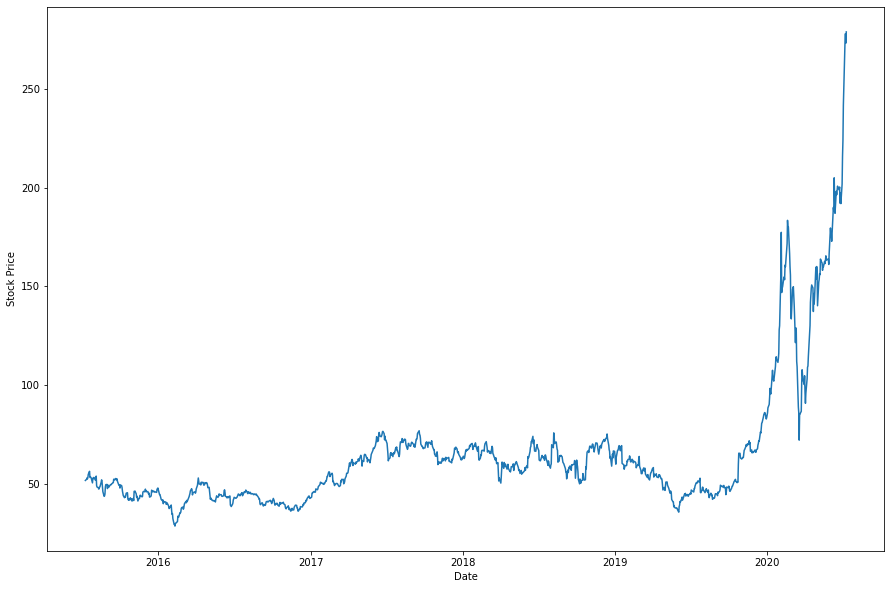

In [38]:
import matplotlib.pyplot as plt

## plot graph
plot_df = df[["Date", "Close"]]
plot_df['Date'] = pd.to_datetime(plot_df['Date'], infer_datetime_format=True) #convert from string to datetime
#Set datatime as dataframe index
plot_df = plot_df.set_index(['Date'])

plt.figure(figsize=(15,10))
plt.plot(plot_df)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

### Extract the column values that you are going to use from pandas dataframe
Here we are going to use the "Close" stock price to do the forecasting

In [13]:
stock = df.iloc[:, 4:5]
# or you can use this following:
# stock = df[["Close"]]

### Get values from dataframe which returns as numpy array

In [14]:
dataset = stock.values

### Normalize the data with Min-Max Normalization

In [15]:
from sklearn.preprocessing import MinMaxScaler

# normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

### split the data into training and test
using first 800 rows for training and the rest 459 for testing

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=459, shuffle=False)

### Create the dataset that we are going to feed to LSTM
Define the function to create the dataset, with time (lag) and dataset as the function parmenters/arguments. 

Then we apply this function on our training and testing dataset with a time-step of 60

In [21]:
import numpy as np

# convert the array of values into a matrix (the format requireb by LSTM)
def create_dataset(dataset, time=1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-time-1):
        a = dataset[i:(i+time), 0]
        data_X.append(a)
        data_Y.append(dataset[i + time, 0])
    return np.array(data_X), np.array(data_Y)

time = 60
train_X, train_Y = create_dataset(train, time)
test_X, test_Y = create_dataset(test, time)

In [22]:
train_X.shape

(739, 60)

### Reshape the data to the input format that required by LSTM
Format that required by LSTM: (samples_size, time-step, features).

In [23]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

### Build a LSTM model
Build a LSTM model with 4 LSTM layer, and each layer with a 50 units/nodes. After each LSTM layer, add a dropout layer with 20% dropout rate. At last, apply a dense layer. Remember to define input_shape in the first layer and set return_sequences = True for all LSTM layer except the layer LSTM layer.

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (train_X.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Compile and train the model
use adam as optimizer and mean_squared_error as the loss function. use batch_size of 32 and epochs of 100 for training, set validation_data as the test dataset to monitor the training process

In [28]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs = 100, batch_size = 32)


Train on 739 samples, validate on 398 samples
Epoch 1/100
739/739 [==============================] - 4s 5ms/step - loss: 0.0025 - val_loss: 0.0215
Epoch 2/100
739/739 [==============================] - 3s 4ms/step - loss: 5.9686e-04 - val_loss: 0.0137
Epoch 3/100
739/739 [==============================] - 3s 4ms/step - loss: 5.1179e-04 - val_loss: 0.0061
Epoch 4/100
739/739 [==============================] - 3s 4ms/step - loss: 4.7047e-04 - val_loss: 0.0066
Epoch 5/100
739/739 [==============================] - 3s 4ms/step - loss: 4.3728e-04 - val_loss: 0.0097
Epoch 6/100
739/739 [==============================] - 3s 4ms/step - loss: 4.2859e-04 - val_loss: 0.0071
Epoch 7/100
739/739 [==============================] - 3s 4ms/step - loss: 4.0503e-04 - val_loss: 0.0093
Epoch 8/100
739/739 [==============================] - 3s 4ms/step - loss: 3.8975e-04 - val_loss: 0.0062
Epoch 9/100
739/739 [==============================] - 3s 4ms/step - loss: 3.7500e-04 - val_loss: 0.0059
Epoch 10/100

Epoch 76/100
739/739 [==============================] - 3s 4ms/step - loss: 1.1771e-04 - val_loss: 0.0031
Epoch 77/100
739/739 [==============================] - 3s 4ms/step - loss: 1.0756e-04 - val_loss: 0.0032
Epoch 78/100
739/739 [==============================] - 3s 4ms/step - loss: 1.1571e-04 - val_loss: 0.0018
Epoch 79/100
739/739 [==============================] - 3s 4ms/step - loss: 1.2103e-04 - val_loss: 0.0030
Epoch 80/100
739/739 [==============================] - 3s 4ms/step - loss: 1.0808e-04 - val_loss: 0.0029
Epoch 81/100
739/739 [==============================] - 3s 4ms/step - loss: 9.5111e-05 - val_loss: 0.0033
Epoch 82/100
739/739 [==============================] - 3s 4ms/step - loss: 9.8929e-05 - val_loss: 0.0019
Epoch 83/100
739/739 [==============================] - 3s 4ms/step - loss: 1.0937e-04 - val_loss: 0.0034
Epoch 84/100
739/739 [==============================] - 3s 4ms/step - loss: 1.2145e-04 - val_loss: 0.0031
Epoch 85/100
739/739 [========================

### Make Predictions
apply model to both training set and testing set

In [29]:
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

### Inverting predictions
transform predictions back with the defined scaler

In [30]:
train_predict = scaler.inverse_transform(train_predict)
train_Y = scaler.inverse_transform([train_Y])
test_predict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform([test_Y])

### Evaluate model performance for both Training and Testing (based on RMSE and R squared)

In [33]:
import math
from sklearn.metrics import mean_squared_error, r2_score

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(train_Y[0], train_predict[:,0]))
print('Train_performance: %.2f RMSE' % (train_score))
test_performance = math.sqrt(mean_squared_error(test_Y[0], test_predict[:,0]))
print('Test_performance: %.2f RMSE' % (test_performance))

# calculate r_squared
train_r_squared = r2_score(train_Y[0], train_predict[:,0])
print('Train_performance: %.2f R2' % (train_r_squared))
test_r_squared = r2_score(test_Y[0], test_predict[:,0])
print('Test_performance: %.2f R2' % (test_r_squared))

Train_performance: 1.86 RMSE
Test_performance: 11.97 RMSE
Train_performance: 0.98 R2
Test_performance: 0.94 R2


### Plot the orginal Data and the Predictions

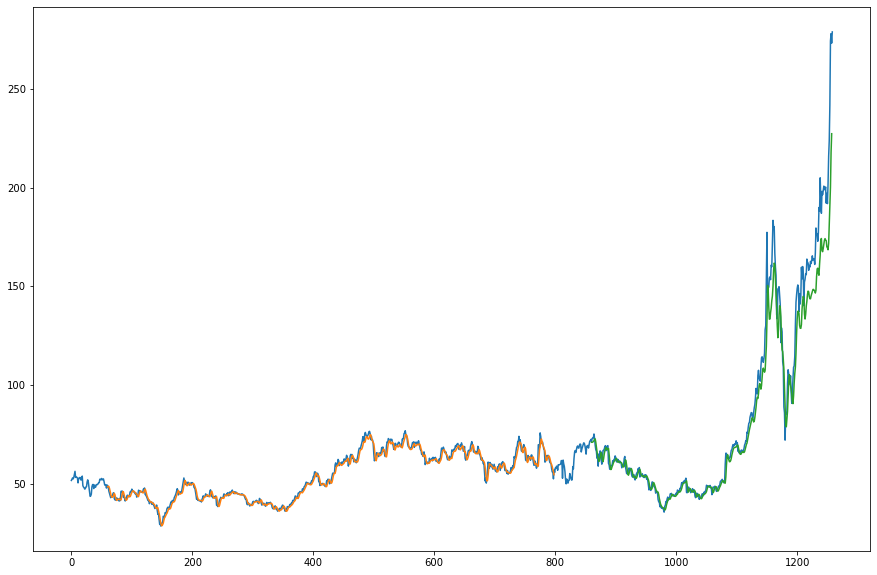

In [40]:
#plotting train and test predictions 
train_plot = np.empty_like(dataset)
train_plot[:, :] = np.nan
train_plot[time:len(train_predict)+time, :] = train_predict

test_plot = np.empty_like(dataset)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(time*2)+1:len(dataset)-1, :] = test_predict

plt.figure(figsize=(15,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()